In [71]:
import numpy as np
import pandas as pd
from gensim.corpora.dictionary import Dictionary #векторное представление текста
import re
from nltk.corpus import stopwords #стоп слова
from razdel import tokenize #токенизация для русского языка
import pymorphy2 #для русского языка
from gensim.models import LdaModel
from gensim.test.utils import datapath
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from itertools import product
from sklearn.pipeline import Pipeline

# 1. Используемые функции

In [7]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    return text

In [8]:
def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

Функция, возвращающая векторное представление новости.

In [9]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

Функция, векторизирующая пользователей.

In [36]:
def get_user_embedding(user_articles_list, how):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = how(user_vector, 0)
    return user_vector

Функция для визуализации confusion matrix.

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Расчёт метрик.

In [117]:
def calc_metrics(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc = roc_auc_score(y_test, preds)
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))

# 2. Глобальные переменные.

In [14]:
cache = {}

In [ ]:
stopword_ru = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

# 3. Получение векторного представления новостей.

In [16]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [17]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [21]:
#подгружаем дополнительные стоп слова
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

Очищаем текст.

In [22]:
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


Делаем лемматизацию.

In [23]:
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Сформируем список текстов, разбив их на пробелы и создадим словарь текстов.

In [24]:
texts = [t for t in news['title'].values]
common_dictionary = Dictionary(texts) #словарь слов
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Реализуем LDA модель.

In [25]:
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)

Чтобы корректно выбрать num_topics, лучше попробовать разные варианты. Есть алгоритмы, которые выкидывают "слабые" темы.

Посмотрим как выглядят темы.

In [26]:
other_texts = [t for t in news['title'].iloc[:5]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(6, 0.091847084), (7, 0.65676165), (16, 0.103185035), (23, 0.12943515)]

In [27]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: египет квартира восток миссия орудие звание школьный
topic_1: военный сша китай год россия боевой космонавт
topic_2: год nn день это который первый наука
topic_3: товар производитель ступень одежда греция чёрный nn
topic_4: который это операция территория погибнуть человек страна
topic_5: это год президент который новый россия свой
topic_6: министерство напомнить кремль выдать бомба железный лекарство
topic_7: это который мочь год всё весь говорить
topic_8: ракета запуск достигать японский определение кг методика
topic_9: научный смерть тело болезнь дональд страдать штат
topic_10: компания год журнал доход население бизнес спрос
topic_11: снизить падение пища лодка опрос инвестировать оказывать
topic_12: год млн составить цена стоимость тыс общий
topic_13: украина украинский наука продукция депутат российский дыра
topic_14: год млрд земля исследование рост область район
topic_15: ребёнок гражданин год университет долг проект программа
topic_16: год обнаружить который nn экипаж

Получим векторные представления новостей.

In [28]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.090934,0.0,0.0,0.0,0.029234,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.871988,0.0,0.000000,0.000000
1,4896,0.0,0.000000,0.000000,0.0,0.0,0.0,0.175885,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.620790,0.0,0.181296,0.000000
2,4897,0.0,0.000000,0.000000,0.0,0.0,0.0,0.091892,0.656722,0.0,...,0.0,0.103185,0.0,0.0,0.0,0.000000,0.000000,0.0,0.129429,0.000000
3,4898,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.685232,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.031100,0.189304
4,4899,0.0,0.420344,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.385691,0.000000,0.0,0.000000,0.000000


# 4. Получение векторного представления пользователей.

Получим матрицу статей, соотвествующих активности пользователя.

In [30]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [31]:
user_articles_list = users['articles'].iloc[33]

In [37]:
get_user_embedding(user_articles_list, how=np.mean)

array([0.        , 0.05729451, 0.022382  , 0.00420108, 0.04346213,
       0.22977146, 0.00209622, 0.08677125, 0.        , 0.01605311,
       0.0173318 , 0.        , 0.01652416, 0.0140101 , 0.        ,
       0.03350346, 0.05878108, 0.01726222, 0.03009501, 0.00321429,
       0.017076  , 0.21856543, 0.        , 0.        , 0.10047429])

Получим эмбеддинги для всех пользователей.

In [39]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, how=np.mean), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.000000,0.129986,0.083599,0.055183,0.154498,0.005579,0.023111,0.000000,...,0.102436,0.030799,0.062713,0.000000,0.000000,0.014896,0.098074,0.005305,0.002709,0.055439
1,u108690,0.000000,0.031651,0.027440,0.003943,0.064439,0.173944,0.010100,0.120405,0.004086,...,0.054199,0.063686,0.003895,0.003790,0.000000,0.011334,0.219145,0.000000,0.000000,0.043182
2,u108339,0.004098,0.018757,0.089077,0.008850,0.107516,0.041443,0.006041,0.005587,0.001836,...,0.019180,0.090730,0.047602,0.032907,0.003293,0.012597,0.295497,0.000000,0.000000,0.012397


# 5. Обучим модель.

In [40]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [41]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.000000,0.129986,0.083599,0.055183,0.154498,0.005579,0.023111,0.000000,...,0.030799,0.062713,0.000000,0.000000,0.014896,0.098074,0.005305,0.002709,0.055439,0
1,u108690,0.000000,0.031651,0.027440,0.003943,0.064439,0.173944,0.010100,0.120405,0.004086,...,0.063686,0.003895,0.003790,0.000000,0.011334,0.219145,0.000000,0.000000,0.043182,1
2,u108339,0.004098,0.018757,0.089077,0.008850,0.107516,0.041443,0.006041,0.005587,0.001836,...,0.090730,0.047602,0.032907,0.003293,0.012597,0.295497,0.000000,0.000000,0.012397,1


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [43]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.19203293, 0.0126116 , 0.42307006, 0.10610597, 0.10157842,
       0.12064648, 0.13200221, 0.01148841, 0.06418707, 0.16295288])

Рассчитаем метрики.

In [66]:
mean = calc_metrics(y_test, preds)

Best Threshold=0.226733, F-Score=0.658, Precision=0.562, Recall=0.792


In [70]:
roc_auc_mean = roc_auc_score(y_test, preds)
roc_auc_mean

0.9477434734577592

Confusion matrix, without normalization
[[1604  151]
 [  52  193]]


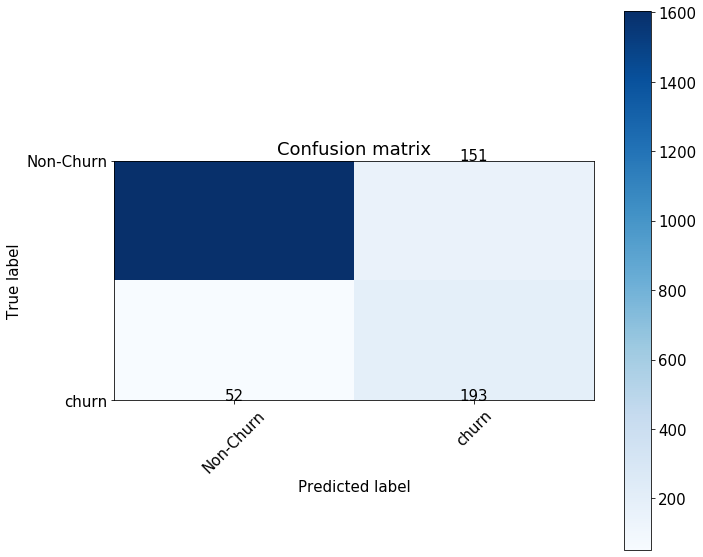

In [59]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Теперь попробуем применить к эмбеддингам медиану и максимальное значение.

In [91]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, how=np.median), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.121174,0.015826,0.000000,0.157678,0.000000,0.000000,0.0,...,0.008471,0.000000,0.027398,0.000000,0.0,0.000000,0.060158,0.0,0.0,0.000000
1,u108690,0.0,0.0,0.000000,0.000000,0.073491,0.145197,0.005552,0.121951,0.0,...,0.052689,0.035461,0.000000,0.000000,0.0,0.000000,0.164920,0.0,0.0,0.034791
2,u108339,0.0,0.0,0.075151,0.000000,0.103176,0.007724,0.000000,0.000000,0.0,...,0.012540,0.092151,0.023284,0.016758,0.0,0.006131,0.359781,0.0,0.0,0.008893


In [92]:
X = pd.merge(user_embeddings, target, 'left')

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [94]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.1887275 , 0.0092547 , 0.45873429, 0.12682418, 0.11349622,
       0.12215564, 0.0934897 , 0.03257512, 0.03484757, 0.2737185 ])

In [99]:
median = calc_metrics(y_test, preds)

Best Threshold=0.242024, F-Score=0.750, Precision=0.674, Recall=0.845


In [100]:
roc_auc_median = roc_auc_score(y_test, preds)
roc_auc_median

0.966498052212338

Результат получился немного лучше, чем с усреднением.

In [101]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, how=np.max), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.00000,0.000000,0.288772,0.346389,0.188223,0.326947,0.033472,0.127629,0.000000,...,0.514310,0.101604,0.227016,0.000000,0.000000,0.089378,0.295079,0.03183,0.016254,0.282563
1,u108690,0.00000,0.189906,0.146608,0.023660,0.091815,0.382336,0.037416,0.255006,0.024514,...,0.110580,0.181568,0.023370,0.022743,0.000000,0.068002,0.431620,0.00000,0.000000,0.129137
2,u108339,0.02459,0.112542,0.206882,0.033080,0.240272,0.185933,0.018604,0.033525,0.011013,...,0.064566,0.195265,0.167108,0.106418,0.019755,0.049311,0.447632,0.00000,0.000000,0.034276


In [102]:
X = pd.merge(user_embeddings, target, 'left')

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [104]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([8.92035830e-02, 7.53708425e-04, 5.17566874e-01, 6.14151084e-02,
       8.63055883e-02, 4.93436686e-02, 1.35048192e-01, 3.00680850e-04,
       1.85757220e-02, 8.96535949e-02])

In [105]:
max_ = calc_metrics(y_test, preds)

Best Threshold=0.323462, F-Score=0.776, Precision=0.749, Recall=0.804


In [106]:
roc_auc_max_ = roc_auc_score(y_test, preds)
roc_auc_max_

0.9728937728937729

Этот результат оказался лучше, чем два предыдущих.

Получили такие результаты, потому что среди топиков было много нулей(незначимых для пользователя тем). Максимальное значение
не учло эти нули, поэтому получили результат лучше. Целесообразно взвешивать документы по Tfidf.

Попробуем TFidf.

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [146]:
user_articles_list.split(',')

['[323329', ' 321961', ' 324743', ' 323186', ' 324632', ' 474690]']

In [156]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [159]:
topic_matrix = pd.DataFrame([TfidfVectorizer.fit_transform(text).idf_ for text in news['title'].values])
#topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
#topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

TypeError: fit_transform() missing 1 required positional argument: 'raw_documents'

In [149]:
user_articles_list = users['articles'].iloc[33]

In [150]:
user_articles_list

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [147]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    vectorizer = TfidfVectorizer(use_idf=True, lowercase=False).fit_transform(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = vectorizer.idf_
    return user_vector

In [148]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

TypeError: expected string or bytes-like object